In [ ]:
!cp '/content/drive/My Drive/Faults/data/synt/dataset_v4_nofda_nonoise.zip' ./
!unzip -qq dataset_v4_nofda_nonoise.zip

!pip install segyio
!pip install obspy

In [2]:
from obspy.io.segy.core import _read_segy as read_segy
from obspy.io.segy.segy import _read_segy
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import cv2
import datetime, os

image_sgy_stream = read_segy('/content/drive/My Drive/Faults/preprocess/sgyprocess/F3_entire.sgy')
image_sgy = np.stack(t.data for t in image_sgy_stream.traces)

data_sgy = np.zeros((651 * 951, 462))
data_sgy.shape

extend_count = data_sgy.shape[0] - image_sgy.shape[0]
extend_count

data_sgy[:image_sgy.shape[0], :] = image_sgy

data_sgy = np.array(data_sgy).reshape(651, 951, 462)
data_sgy_reshaped = data_sgy
data_sgy.shape

data_sgy = data_sgy[:500, :, :]
data_sgy.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(500, 951, 462)

In [3]:
cube = np.fromfile('/content/content/dataset/traces/0.dat', dtype=np.float32)
cube_label = np.fromfile('/content/content/dataset/labels/0.dat', dtype=np.float32)
cube = np.reshape(cube, [128, 128, 128])
cube_label = np.reshape(cube_label, [128, 128, 128])
cube.shape

(128, 128, 128)

In [4]:
start_x, start_y, start_z = 100, 200, 300
size = 128
real_slice = data_sgy[start_x: start_x + size, start_y: start_y + size, start_z: start_z + size]
real_slice.shape

(128, 128, 128)

In [5]:
#@title slice viewer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from ipywidgets.widgets import *
from ipywidgets import widgets
from IPython.display import display

plt.style.use('seaborn-white')



class SliceViewer():

    '''
        Arguments: 
            traces_volume - np.array with shape (nx, ny, nz)
            labels_volume - np.array with shape (nx, ny, nz)
            figsize - tuple, plot size

    '''

    def __init__(self, traces_volume, labels_volume,
                 figsize=(7, 7), tr_cmap='gray', lb_cmap='Greens'):

        assert traces_volume.shape == labels_volume.shape, 'Shapes must be equal'

        self.tr_volume = traces_volume
        self.lb_volume = labels_volume
        self.figsize = figsize
        self.tr_cmap = tr_cmap
        self.lb_cmap = lb_cmap

        self.nx, self.ny, self.nz = self.tr_volume.shape

        self.widget = self.__create_widget()


    def __create_widget(self):

        x_slider = IntSlider(min=0, max=self.nx - 1, step=1, value=int(self.nx/2))
        y_slider = IntSlider(min=0, max=self.ny - 1, step=1, value=int(self.ny/2))
        z_slider = IntSlider(min=0, max=self.nz - 1, step=1, value=int(self.nz/2))
        alpha = IntSlider(min=0, max=100, step=5, value=70)
        selector = ['x','y','z']
        w = interact(self.__show, x=x_slider, y=y_slider,
                     z=z_slider, alpha=alpha, dim=selector)

        return w

    
    def __get_slice(self, x, y, z, dim):

        if dim == 'x':
            tr = self.tr_volume[x, :, :]
            lb = self.lb_volume[x, :, :]
        elif dim == 'y':
            tr = self.tr_volume[:, y, :]
            lb = self.lb_volume[:, y, :]
        else:
            tr = self.tr_volume[:, :, z]
            lb = self.lb_volume[:, :, z]
        
        return tr, lb


    def __set_labels(self, ax, dim):

        if dim == 'x':
            ax.set_xlabel('y')
            ax.set_ylabel('z')
        elif dim == 'y':
            ax.set_xlabel('x')
            ax.set_ylabel('z')
        else:
            ax.set_xlabel('y')
            ax.set_ylabel('x')

    
    def __show(self, x, y, z, alpha, dim):

        tr, lb = self.__get_slice(x, y, z, dim)

        fig, ax = plt.subplots(figsize=self.figsize)
        plt.imshow(tr.T, cmap=self.tr_cmap, aspect='equal')
        plt.imshow(lb.T, alpha=(100-alpha)/100, aspect='equal', cmap=self.lb_cmap)
        self.__set_labels(ax, dim)
        plt.grid()
        plt.show()
        display()

        ax.set_xlabel('x')
        ax.set_ylabel('z')


In [6]:
SliceViewer(real_slice, real_slice, figsize=(8, 8), tr_cmap='gray', lb_cmap='gray')

interactive(children=(IntSlider(value=64, description='x', max=127), IntSlider(value=64, description='y', max=…

In [7]:
SliceViewer(cube, cube_label, figsize=(8, 8), tr_cmap='gray')

interactive(children=(IntSlider(value=64, description='x', max=127), IntSlider(value=64, description='y', max=…

In [8]:
from imgaug import augmenters as iaa


seq_elastic = iaa.Sequential([
    # alpha - смещение, sigma - блюр
    iaa.ElasticTransformation(alpha=(15, 15), sigma=(6.0, 6.0)),
])

seq_piec = iaa.Sequential([
    iaa.PiecewiseAffine(scale=(0.03, 0.03)), # 0.01 0.03 recommend
])

edge = iaa.Sequential([
        # iaa.DirectedEdgeDetect(alpha=(1.0, 1.0), direction=(0.0, 0.0))
        
])


# Equalize

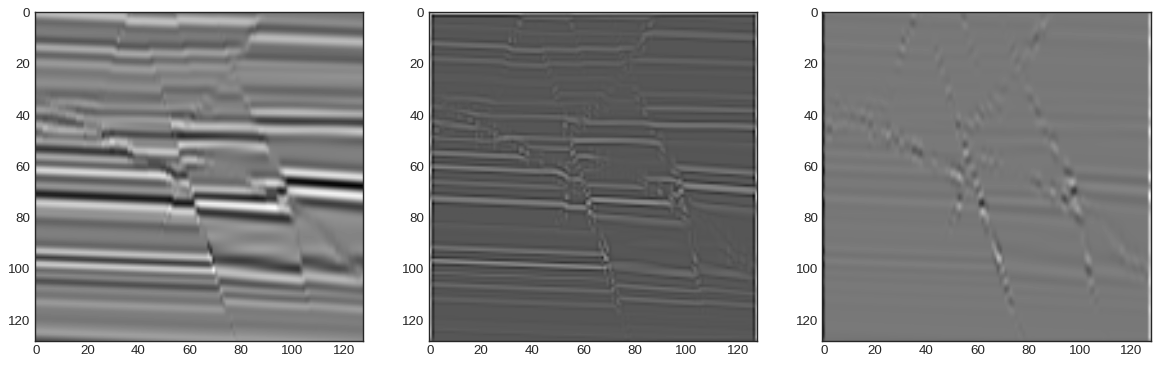

In [73]:
import cv2
import tensorflow as tf


def gabor_filtering(image, theta, sigma, lambd):
   """
   Using Gabor Filters to repair
   motion blurriness in an image.
   """

   image = image[None, ..., None]
   theta = theta
   filtered_images = []
   sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
   for th in theta :
      kernel = cv2.getGaborKernel(ksize = (3, 3), sigma=sigma, lambd=lambd, theta = th, 
               gamma = 0.25)
      kernel = tf.expand_dims(kernel, -1)
      kernel = tf.expand_dims(kernel, -1)
      
      kernel = tf.cast(kernel, tf.float32)
      filtered_images.append(tf.nn.conv2d(image, kernel, strides=[1, 1, 1, 1], 
                             padding='SAME'))
      
   final_img = tf.math.maximum(tf.math.maximum(filtered_images[0], 
   filtered_images[1]), tf.math.maximum(filtered_images[2], filtered_images[3]))

   #Sharpening the image
   sharpen_kernel = tf.expand_dims(sharpen_kernel, -1)
   sharpen_kernel = tf.expand_dims(sharpen_kernel, -1)
   sharpen_kernel = tf.cast(sharpen_kernel, tf.float32)

   return filtered_images, tf.nn.conv2d(final_img, sharpen_kernel, strides=[1, 1, 1, 1], 
                       padding='SAME')
   


image = cube[70].T.copy()

theta = [0, 45, 90, 135]
sigma = 5
lambd = 4
# theta = [0, 3, 6, 9, 12]


filtered_images, aug = gabor_filtering(image, theta, sigma, lambd)

fil = filtered_images[3].numpy().squeeze()

aug = aug.numpy().squeeze()

fig, axs = plt.subplots(1, 3, figsize=(18, 18))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(aug, cmap='gray')
axs[2].imshow(fil, cmap='gray')

In [10]:

def scale_min_max(x):
    x = (x - x.min()) / (x.max() - x.min())
    return x    


def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask


def low_freq_mutate_np( amp_src, amp_trg, L, circle, transfer):
    a_src = np.fft.fftshift( amp_src, axes=(-2, -1) )
    a_trg = np.fft.fftshift( amp_trg, axes=(-2, -1) )

    _, h, w = a_src.shape
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)
    c_h = np.floor(h/2.0).astype(int)
    c_w = np.floor(w/2.0).astype(int)

    h1 = c_h-b
    h2 = c_h+b+1
    w1 = c_w-b
    w2 = c_w+b+1

    if circle:
        mask = create_circular_mask(h, w, radius=b)
        if transfer:
            a_src = np.where(mask, a_trg, a_src)
        else:
            a_src = np.where(mask, np.zeros_like(a_trg), a_src)    
    else:
        if transfer:
            a_src[:,h1:h2,w1:w2] = a_trg[:,h1:h2,w1:w2]
        else:
            a_src[:,h1:h2,w1:w2] = np.zeros_like(a_trg[:,h1:h2,w1:w2])

    a_src = np.fft.ifftshift( a_src, axes=(-2, -1) )
    return a_src


def FDA_source_to_target_np(src_img, trg_img, L=0.1, circle=False, transfer=True):
    # exchange magnitude
    # input: src_img, trg_img

    src_img = src_img[..., None].transpose((2, 0, 1))

    trg_img = trg_img[..., None].transpose((2, 0, 1))


    src_img_np = src_img #.cpu().numpy()
    trg_img_np = trg_img #.cpu().numpy()

    # get fft of both source and target
    fft_src_np = np.fft.fft2( src_img_np, axes=(-2, -1) )
    fft_trg_np = np.fft.fft2( trg_img_np, axes=(-2, -1) )

    # extract amplitude and phase of both ffts
    amp_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)
    amp_trg, pha_trg = np.abs(fft_trg_np), np.angle(fft_trg_np)

    # mutate the amplitude part of source with target
    amp_src_ = low_freq_mutate_np( amp_src, amp_trg, L, circle, transfer)

    # mutated fft of source
    fft_src_ = amp_src_ * np.exp( 1j * pha_src )

    # get the mutated image
    src_in_trg = np.fft.ifft2( fft_src_, axes=(-2, -1) )
    src_in_trg = np.real(src_in_trg)

    return src_in_trg

In [ ]:
!pip install --upgrade scikit-image

/usr/local/lib/python3.6/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  mask = img_as_ubyte(mask)


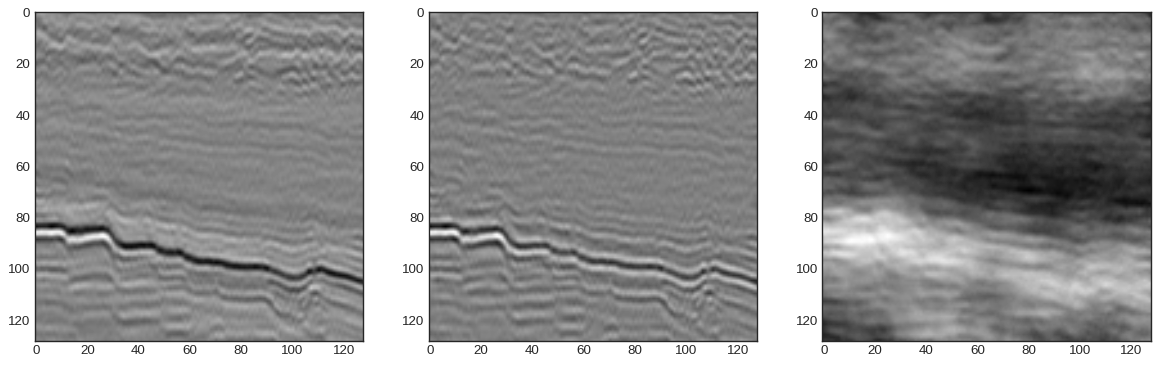

In [121]:
from skimage import exposure
from skimage.filters import unsharp_mask
from skimage.filters.rank import entropy
from skimage.morphology import disk


# source = scale_min_max(cube[30]).T
# target = scale_min_max(real_slice[0]).T


target = scale_min_max(cube[40]).T
source = scale_min_max(real_slice[30]).T

# test for horizons
# entr_img = entropy(fda, disk(10))


# https://scikit-image.org/docs/dev/auto_examples/filters/plot_window.html#sphx-glr-auto-examples-filters-plot-window-py
# !!!!!!!!!!!!!!!!!!!! add circle to FDA
# wsource = source * window('hann', source.shape)
# wtarget = target * window('hann', target.shape)
# fda = FDA_source_to_target_np(wsource, wtarget, L=0.12, circle=True, transfer=False).squeeze()


fda = FDA_source_to_target_np(source, target, L=0.12, circle=True, transfer=False).squeeze()



fig, axs = plt.subplots(1, 3, figsize=(18, 18))
axs[0].imshow(source, cmap='gray')
axs[1].imshow(fda, cmap='gray')
axs[2].imshow(entr_img, cmap='gray')

26 103 26 103


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log


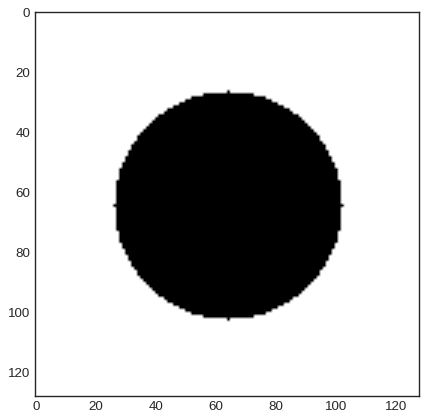

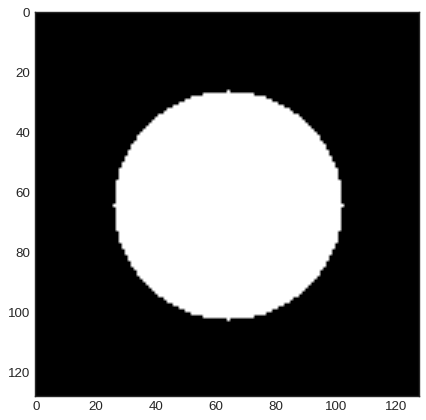

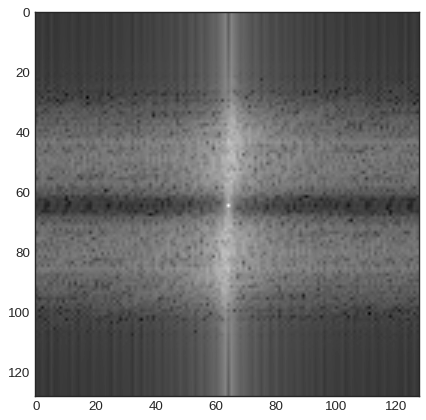

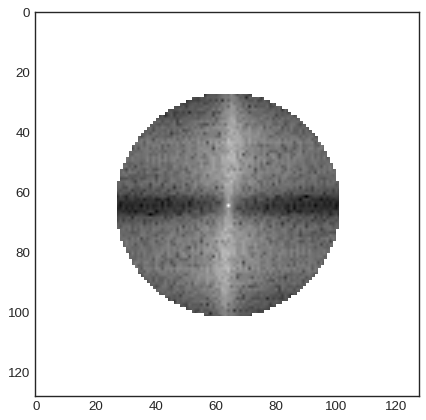

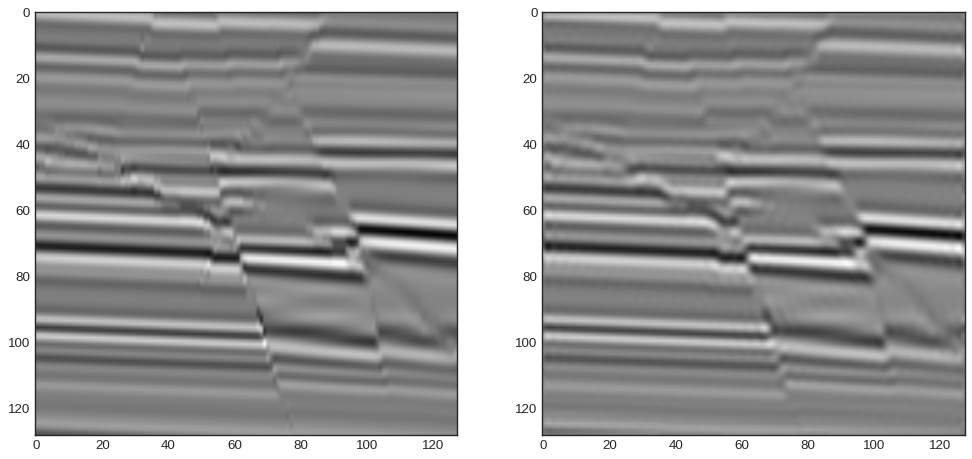

In [100]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask


test_slice = scale_min_max(cube[70]).T
# test_slice = scale_min_max(real_slice[30]).T

L = 0.3


src_img = test_slice[None, ...]

fft_src_np = np.fft.fft2(src_img, axes=(-2, -1))

a_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)

a_src = np.fft.fftshift(a_src, axes=(-2, -1) )

_, h, w = a_src.shape
b = (  np.floor(np.amin((h,w))*L)  ).astype(int)
c_h = np.floor(h/2.0).astype(int)
c_w = np.floor(w/2.0).astype(int)

b_h = b
b_w = b

h1 = c_h-b_h
h2 = c_h+b_h+1

w1 = c_w-b_w
w2 = c_w+b_w+1

print(h1, h2, w1, w2)
mask = np.zeros_like(a_src)



mask[:,h1:h2,w1:w2] = 1

mask = create_circular_mask(h, w, radius=b_w)

plt.figure()
plt.imshow(mask.squeeze())

mask = np.logical_not(mask)

plt.figure()
plt.imshow(mask.squeeze())


plt.figure()
magnitude_spectrum = 20*np.log(a_src)
plt.imshow(magnitude_spectrum.squeeze(), cmap='gray')


a_src = np.where(mask, np.zeros_like(a_src), a_src)
#a_src = np.where(mask, np.ones_like(a_src), a_src)


plt.figure()
magnitude_spectrum = 20*np.log(a_src)
plt.imshow(magnitude_spectrum.squeeze(), cmap='gray')





a_src = np.fft.ifftshift(a_src, axes=(-2, -1) )



fft_src_ = a_src * np.exp( 1j * pha_src)

test_slice_no_fr = np.fft.ifft2( fft_src_, axes=(-2, -1) )

test_slice_no_fr = np.real(test_slice_no_fr)




fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(test_slice.squeeze(), cmap='gray')
axs[1].imshow(test_slice_no_fr.squeeze(), cmap='gray')

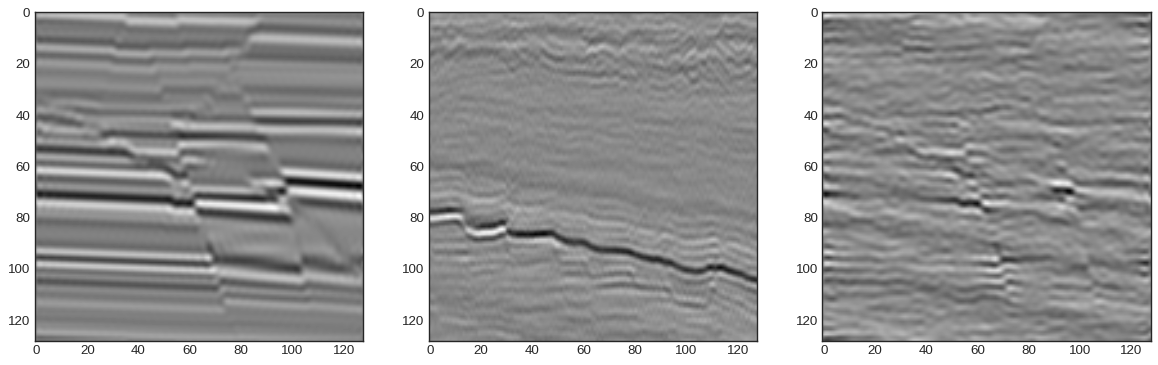

In [101]:

source = scale_min_max(test_slice_no_fr.squeeze())
target = scale_min_max(real_slice[0]).T



fda = FDA_source_to_target_np(source, target, L=0.3, circle=True, transfer=True).squeeze()


fig, axs = plt.subplots(1, 3, figsize=(18, 18))
axs[0].imshow(source, cmap='gray')
axs[1].imshow(target, cmap='gray')
axs[2].imshow(fda, cmap='gray')

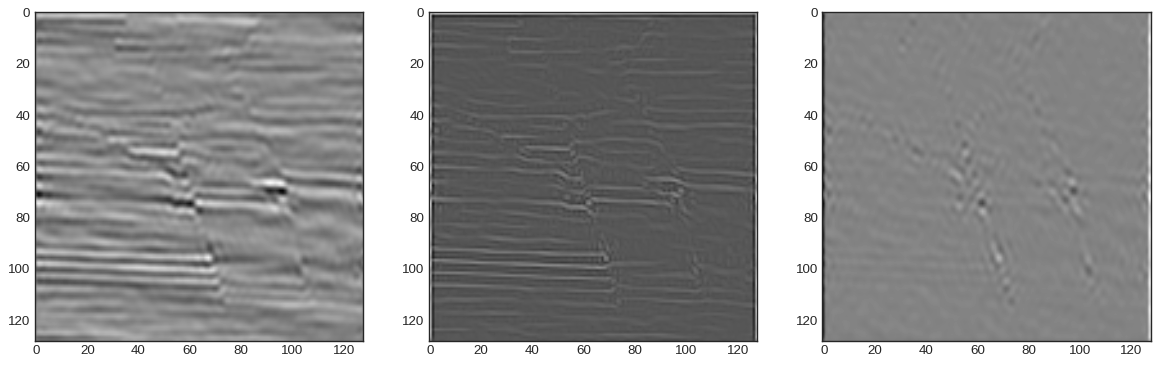

In [72]:

theta = [0, 45, 90, 135]
sigma = 5
lambd = 4
# theta = [0, 3, 6, 9, 12]


filtered_images, aug = gabor_filtering(fda, theta, sigma, lambd)


fil = filtered_images[3].numpy().squeeze()

aug = aug.numpy().squeeze()

fig, axs = plt.subplots(1, 3, figsize=(18, 18))
axs[0].imshow(fda, cmap='gray')
axs[1].imshow(aug, cmap='gray')
axs[2].imshow(fil, cmap='gray')